### Imports and preparation

In [48]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
import pandas as pd

# Create a SparkSessoin
spark = SparkSession.builder.appName('ml-road').getOrCreate()

# Read Excel file into Pandas dataframe
df_crashes_pd = pd.read_excel('./bitre_fatal_crashes_aug2023.xlsx',sheet_name='BITRE_Fatal_Crash',skiprows=4)

# Create custom schemas
schema_crashes = StructType([
    StructField("CRASH_ID", StringType(), False), 
    StructField("STATE", StringType(), True),
    StructField("MONTH", StringType(), True),
    StructField("YEAR", IntegerType(), True),
    StructField("DAYWEEK", StringType(), True),
    StructField("TIME", StringType(), True),
    StructField("CRASH_TYPE", StringType(), True),
    StructField("NUMBER_FATALITIES", IntegerType(), True),
    StructField("BUS_INVOLVEMENT", StringType(), True),
    StructField("HEAVY_TRUCK_INVOLVEMENT", StringType(), True),
    StructField("ARTICULATED_TRUCK_INVOLVEMENT", StringType(), True),
    StructField("SPEED_LIMIT", StringType(), True),
    StructField("NATIONAL_REMOTENESS", StringType(), True),
    StructField("SA4_NAME", StringType(), True),
    StructField("NATIONAL_LGA", StringType(), True),
    StructField("NATIONAL_ROAD_TYPE", StringType(), True),
    StructField("CHRISTMAS", StringType(), True),
    StructField("EASTER", StringType(), True),
    StructField("DAYOFWEEK", StringType(), True),
    StructField("TIMEOFDAY", StringType(), True)
])



# Convert Pandas dataframe to Spark dataframe
df_crashes_spark = spark.createDataFrame(df_crashes_pd, schema_crashes)

# Show top 3 rows
df_crashes_spark.show(3)


+--------+-----+-----+----+--------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+------------------+---------+------+---------+---------+
|CRASH_ID|STATE|MONTH|YEAR| DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|NATIONAL_LGA|NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|
+--------+-----+-----+----+--------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+------------------+---------+------+---------+---------+
|20232113|  Vic|    8|2023|Saturday|Time: 16 hours, 9...|  Multiple|                1|             -9|                     -9|                           -9|    

### Clean data


In [49]:
# Remove '-9's 

# Define the condition to remove rows with '-9' or 'NaN' in any column
condition = (
    (df_crashes_spark.STATE != '-9') &
    (df_crashes_spark.MONTH != '-9') &
    (df_crashes_spark.YEAR != '-9') &
    (df_crashes_spark.DAYWEEK != '-9') &
    (df_crashes_spark.TIME != '-9') &
    (df_crashes_spark.CRASH_TYPE != '-9') &
    (df_crashes_spark.NUMBER_FATALITIES != '-9') &
    (df_crashes_spark.BUS_INVOLVEMENT != '-9') &
    (df_crashes_spark.HEAVY_TRUCK_INVOLVEMENT != '-9') &
    (df_crashes_spark.ARTICULATED_TRUCK_INVOLVEMENT != '-9') &
    (df_crashes_spark.SPEED_LIMIT != '-9') &
    (df_crashes_spark.CHRISTMAS != '-9') &
    (df_crashes_spark.EASTER != '-9') &
    (df_crashes_spark.DAYOFWEEK != '-9') &
    (df_crashes_spark.TIMEOFDAY != '-9')
)

# Apply the filter
df_crashes_spark = df_crashes_spark.filter(condition)

# Show the resulting DataFrame
df_crashes_spark.show()


+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|        NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+
|20235045|   WA|    8|2023|   Sunday|Time: 9 hours, 5 ...|    Single|                1|             No|                     No|

In [50]:
from pyspark.sql.functions import col, lower, trim

# Define the condition to remove rows with 'NaN' in any column (case-insensitive and with whitespace trimmed)
condition = (
    (lower(trim(col("STATE"))) != 'nan') &
    (lower(trim(col("MONTH"))) != 'nan') &
    (lower(trim(col("YEAR"))) != 'nan') &
    (lower(trim(col("DAYWEEK"))) != 'nan') &
    (lower(trim(col("TIME"))) != 'nan') &
    (lower(trim(col("CRASH_TYPE"))) != 'nan') &
    (lower(trim(col("NUMBER_FATALITIES"))) != 'nan') &
    (lower(trim(col("SPEED_LIMIT"))) != 'nan') &
    (lower(trim(col("CHRISTMAS"))) != 'nan') &
    (lower(trim(col("EASTER"))) != 'nan') &
    (lower(trim(col("DAYOFWEEK"))) != 'nan') &
    (lower(trim(col("TIMEOFDAY"))) != 'nan')
)

# Apply the filter
df_crashes_spark = df_crashes_spark.filter(condition)

df_crashes_spark = df_crashes_spark.na.drop()

# Show the resulting DataFrame
df_crashes_spark.show()


+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|        NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+--------------------+--------------------+---------+------+---------+---------+
|20235045|   WA|    8|2023|   Sunday|Time: 9 hours, 5 ...|    Single|                1|             No|                     No|

### Summary stats for numeric variables

In [51]:
# Summary stats for crash data
numeric_features2 = [t[0] for t in df_crashes_spark.dtypes if t[1] == 'int']
df_crashes_spark.select(numeric_features2).describe().toPandas().transpose()

0                   1                    2     3     4
summary            count                mean               stddev   min   max
YEAR               30974  2008.8521340479112    8.757447488401667  1989  2023
NUMBER_FATALITIES  30974  1.0983728288241752  0.38248795091512594     1    11

### Join Datasets


Joining crashes dataset with locations database to see if there is any association. 

In [52]:
import geopandas as gpd

geography_type = "SSC"

# location keys 
geography_type_fields = { 
    "SA1": { "geo_key": "SA1_7DIGIT", "data_key": "SA1_7DIGITCODE_2016" },
    "SA2": { "geo_key": "SA2_7DIGIT", "data_key": "SA2_7DIGITCODE_2016" },
    "SA3": { "geo_key": "SA3_7DIGIT", "data_key": "SA3_7DIGITCODE_2016" },
    "SA4": { "geo_key": "SA4_CODE", "data_key": "SA4_CODE_2016" },
    "SSC": { "geo_key": "SSC_CODE", "data_key": "SSC_CODE_2016" },
}
geo_key = geography_type_fields[geography_type]["geo_key"]
data_key = geography_type_fields[geography_type]["data_key"]

<Axes: >

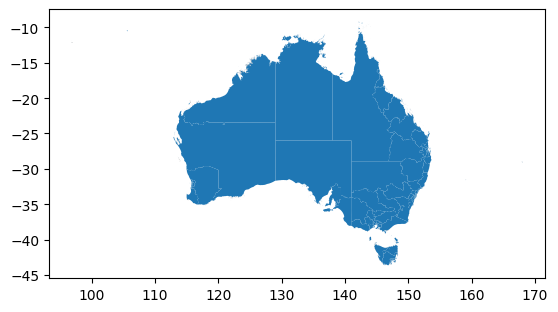

In [53]:
shapes = "./shapes/SA4_2016_AUST.shp"

shapes_gpd = gpd.read_file(shapes)

shapes_gpd.plot()

In [54]:
result_gdf = pd.merge(shapes_gpd, df_crashes_spark.toPandas())


In [55]:
result_gdf

SA4_CODE SA4_CODE16                SA4_NAME STATE_CODE  STATE_NAME   
0         212        212  Melbourne - South East          2    Victoria  \
1         212        212  Melbourne - South East          2    Victoria   
2         212        212  Melbourne - South East          2    Victoria   
3         212        212  Melbourne - South East          2    Victoria   
4         212        212  Melbourne - South East          2    Victoria   
...       ...        ...                     ...        ...         ...   
8791      310        310                 Ipswich          3  Queensland   
8792      310        310                 Ipswich          3  Queensland   
8793      310        310                 Ipswich          3  Queensland   
8794      310        310                 Ipswich          3  Queensland   
8795      310        310                 Ipswich          3  Queensland   

      AREA_SQKM                                           geometry  CRASH_ID   
0     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232037  \
1     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232013   
2     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232127   
3     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232106   
4     1922.2805  POLYGON ((145.76502 -37.89858, 145.76514 -37.8...  20232076   
...         ...                                                ...       ...   
8791  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173090   
8792  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173074   
8793  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173205   
8794  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173136   
8795  6681.1469  POLYGON ((152.96541 -27.54463, 152.96697 -27.5...  20173224   

     STATE MONTH  ...  HEAVY_TRUCK_INVOLVEMENT ARTICULATED_TRUCK_INVOLVEMENT   
0      Vic     7  ...                       No                            No  \
1      Vic     7  ...                       No                            No   
2      Vic     6  ...                       No                            No   
3      Vic     6  ...                       No                            No   
4      Vic     5  ...                       No                           Yes   
...    ...   ...  ...                      ...                           ...   
8791   Qld     6  ...                       No                            No   
8792   Qld     5  ...                       No                           Yes   
8793   Qld     4  ...                       No                            No   
8794   Qld     3  ...                       No                            No   
8795   Qld     2  ...                       No                            No   

     SPEED_LIMIT        NATIONAL_REMOTENESS       NATIONAL_LGA   
0             50  Major Cities of Australia              Casey  \
1             80  Major Cities of Australia  Greater Dandenong   
2             60  Major Cities of Australia             Monash   
3             60  Major Cities of Australia              Casey   
4             80  Major Cities of Australia              Casey   
...          ...                        ...                ...   
8791          50  Major Cities of Australia           Brisbane   
8792         100   Inner Regional Australia           Somerset   
8793          60   Inner Regional Australia           Somerset   
8794         100   Inner Regional Australia         Scenic Rim   
8795         100   Inner Regional Australia           Somerset   

             NATIONAL_ROAD_TYPE CHRISTMAS EASTER DAYOFWEEK TIMEOFDAY  
0             Sub-arterial Road        No     No   Weekday     Night  
1                 Arterial Road        No     No   Weekday       Day  
2             Sub-arterial Road        No     No   Weekend     Night  
3                    Local Road        No     No   Weekday       Day  
4             Sub-arterial Road   

<Axes: >

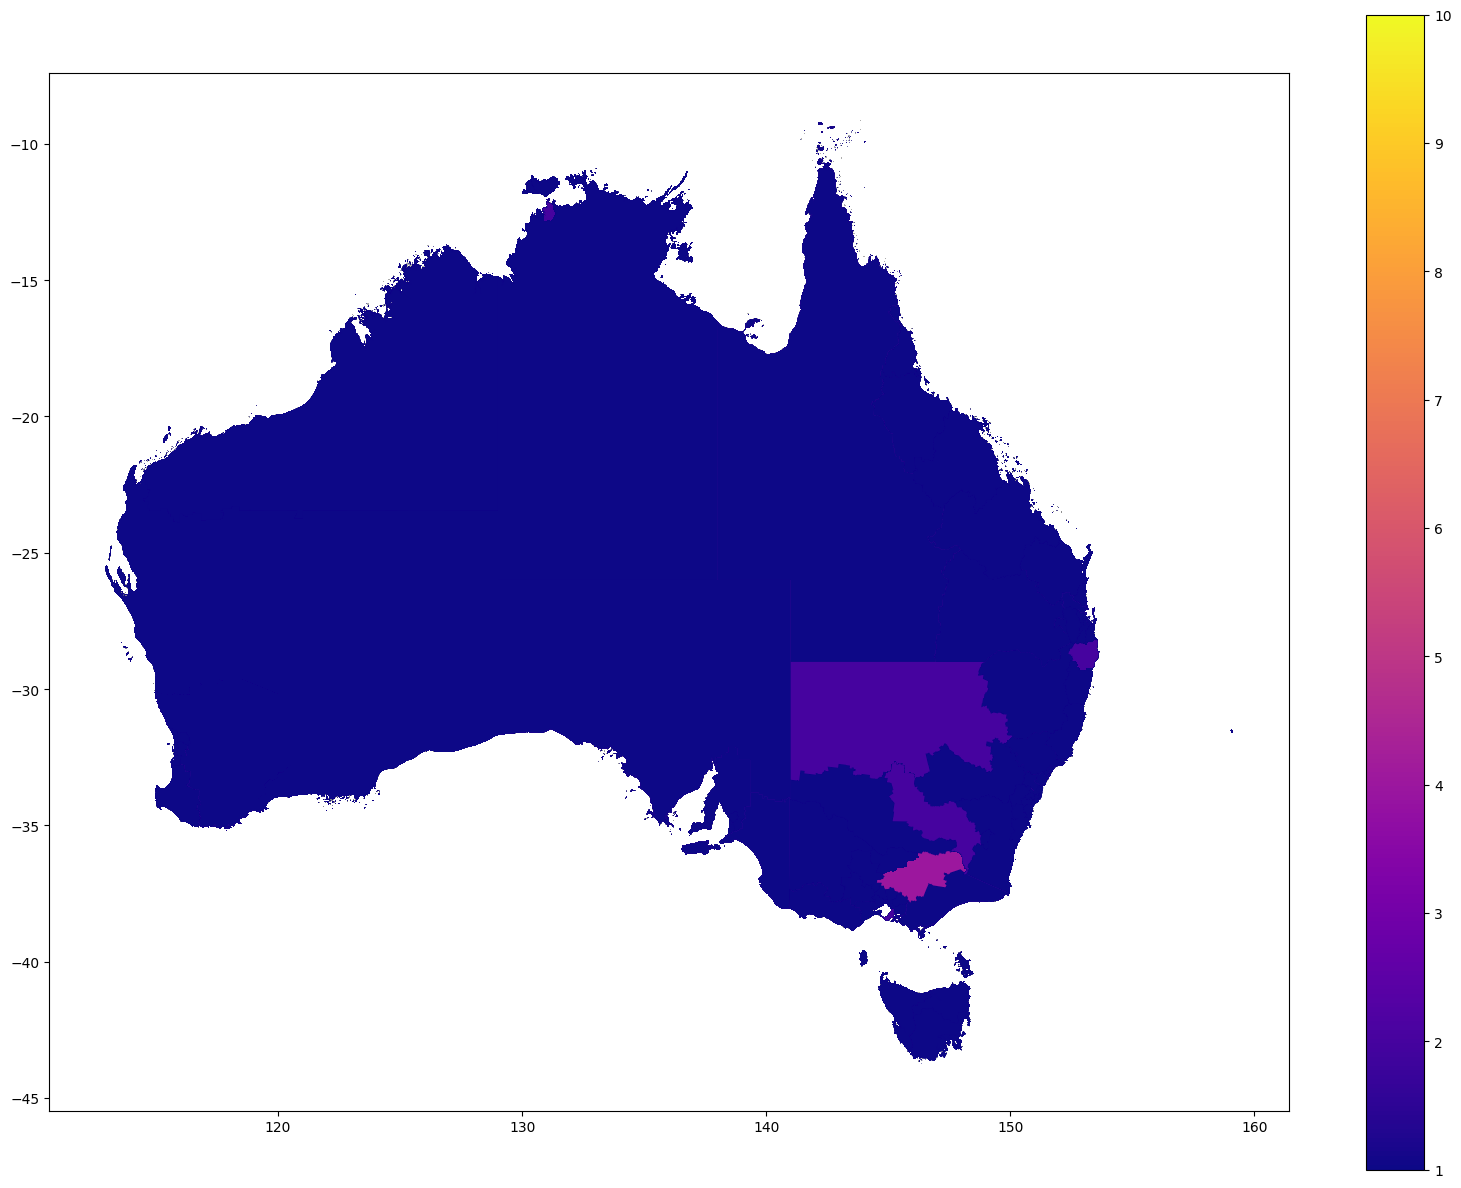

In [56]:
# Plot the choropleth map based on the aggregated NUMBER_FATALITIES values
result_gdf.plot(column='NUMBER_FATALITIES', legend=True, figsize=(20, 15), cmap='plasma')

In [57]:
# Checking outliers for fatalities
 
df_crashes_sorted = df_crashes_spark.orderBy('NUMBER_FATALITIES', ascending=False)

top_10_fatalities = df_crashes_sorted.limit(10)

top_10_fatalities.show()

+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+--------------------+---------+------+---------+---------+
|CRASH_ID|STATE|MONTH|YEAR|  DAYWEEK|                TIME|CRASH_TYPE|NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|SPEED_LIMIT| NATIONAL_REMOTENESS|            SA4_NAME|NATIONAL_LGA|  NATIONAL_ROAD_TYPE|CHRISTMAS|EASTER|DAYOFWEEK|TIMEOFDAY|
+--------+-----+-----+----+---------+--------------------+----------+-----------------+---------------+-----------------------+-----------------------------+-----------+--------------------+--------------------+------------+--------------------+---------+------+---------+---------+
|20072222|  Vic|    6|2007|  Tuesday|Time: 13 hours, 3...|  Multiple|               11|             No|                     No|                        

In [58]:
from pyspark.sql.functions import col, avg

# Group by 'SA4_NAME' and calculate the average 'NUMBER_FATALITIES'
grouped_df = df_crashes_spark.groupBy('SA4_NAME').agg(avg('NUMBER_FATALITIES').alias('AvgFatalities'))

# Sort the DataFrame by 'AvgFatalities' in descending order and limit to the top 10 records
top_10_sa4_by_avg_fatalities = grouped_df.orderBy(col('AvgFatalities').desc()).limit(10)

# Show the top 10 SA4_NAME values with the highest average Number Fatalities
top_10_sa4_by_avg_fatalities.show()

+--------------------+------------------+
|            SA4_NAME|     AvgFatalities|
+--------------------+------------------+
|Northern Territor...|1.1787709497206704|
|Sydney - Outer So...|1.1746031746031746|
|Darling Downs - M...|1.1694915254237288|
|          Townsville|1.1473684210526316|
|Western Australia...| 1.146341463414634|
|Western Australia...|1.1411764705882352|
|              Cairns|1.1363636363636365|
|            Ballarat|1.1333333333333333|
|South Australia -...|1.1333333333333333|
|Barossa - Yorke -...| 1.129251700680272|
+--------------------+------------------+



In [59]:
df_crashes_spark.printSchema()

root
 |-- CRASH_ID: string (nullable = false)
 |-- STATE: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- DAYWEEK: string (nullable = true)
 |-- TIME: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- NATIONAL_REMOTENESS: string (nullable = true)
 |-- SA4_NAME: string (nullable = true)
 |-- NATIONAL_LGA: string (nullable = true)
 |-- NATIONAL_ROAD_TYPE: string (nullable = true)
 |-- CHRISTMAS: string (nullable = true)
 |-- EASTER: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)



In [60]:
# Choose columns
df_crashes_spark = df_crashes_spark.na.drop()

df_crashes_spark = df_crashes_spark.select('CRASH_ID', 'DAYWEEK', 'CRASH_TYPE', 'NUMBER_FATALITIES', 'BUS_INVOLVEMENT', 'HEAVY_TRUCK_INVOLVEMENT', 'ARTICULATED_TRUCK_INVOLVEMENT', 'SPEED_LIMIT', 'DAYOFWEEK', 'TIMEOFDAY')

cols = df_crashes_spark.columns
df_crashes_spark.printSchema()

root
 |-- CRASH_ID: string (nullable = false)
 |-- DAYWEEK: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)



### Preparing data for machine learning


In [61]:
import pyspark
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from distutils.version import LooseVersion

# Category Indexing
categoricalColumns = ['CRASH_ID', 'DAYWEEK', 'CRASH_TYPE', 'BUS_INVOLVEMENT', 'HEAVY_TRUCK_INVOLVEMENT', 'ARTICULATED_TRUCK_INVOLVEMENT', 'SPEED_LIMIT', 'DAYOFWEEK', 'TIMEOFDAY']
stages = []

# From databricks website. Convert categorical column into vector. 
for categoricalCol in categoricalColumns:
    outputColName = categoricalCol + 'Index'
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = outputColName)
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    if LooseVersion(pyspark.__version__) < LooseVersion("3.0"):
        from pyspark.ml.feature import OneHotEncoderEstimator
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    else:
        from pyspark.ml.feature import OneHotEncoder
        encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'NUMBER_FATALITIES', outputCol = 'label')
stages += [label_stringIdx]
#numericCols = ['NUMBER_FATALITIES']
assemblerInputs = [c + "classVec" for c in categoricalColumns] #+ numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

### Pipeline


In [62]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df_crashes_spark)
df_transformed = pipelineModel.transform(df_crashes_spark)
selectedCols = ['label', 'features'] + cols
df_transformed = df_transformed.select(selectedCols)
df_transformed.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- CRASH_ID: string (nullable = false)
 |-- DAYWEEK: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- NUMBER_FATALITIES: integer (nullable = true)
 |-- BUS_INVOLVEMENT: string (nullable = true)
 |-- HEAVY_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- ARTICULATED_TRUCK_INVOLVEMENT: string (nullable = true)
 |-- SPEED_LIMIT: string (nullable = true)
 |-- DAYOFWEEK: string (nullable = true)
 |-- TIMEOFDAY: string (nullable = true)



In [63]:
# Split data into train and test
train, test = df_transformed.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

23/10/16 20:44:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Training Dataset Count: 21805


23/10/16 20:45:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


Test Dataset Count: 9169


### Logistic Regression Model

In [64]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

23/10/16 20:45:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:07 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:07 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
23/10/16 20:45:10 WARN DAGScheduler: Broadcasting larg

In [65]:
train.describe().show()

23/10/16 20:45:19 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


+-------+-------------------+-------------------+---------+----------+------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+
|summary|              label|           CRASH_ID|  DAYWEEK|CRASH_TYPE| NUMBER_FATALITIES|BUS_INVOLVEMENT|HEAVY_TRUCK_INVOLVEMENT|ARTICULATED_TRUCK_INVOLVEMENT|       SPEED_LIMIT|DAYOFWEEK|TIMEOFDAY|
+-------+-------------------+-------------------+---------+----------+------------------+---------------+-----------------------+-----------------------------+------------------+---------+---------+
|  count|              21805|              21805|    21805|     21805|             21805|          21805|                  21805|                        21805|             21805|    21805|    21805|
|   mean|0.09717954597569364|2.014165364352213E7|     null|      null| 1.097500573263013|           null|                   null|                         null| 82.00009174732786|     null|     null|
| std

23/10/16 20:45:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


In [66]:
import matplotlib.pyplot as plt
import numpy as np

beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

Py4JJavaError: An error occurred while calling o4273.coefficients.
: org.apache.spark.SparkException: Multinomial models contain a matrix of coefficients, use coefficientMatrix instead.
	at org.apache.spark.ml.classification.LogisticRegressionModel.coefficients(LogisticRegression.scala:1085)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


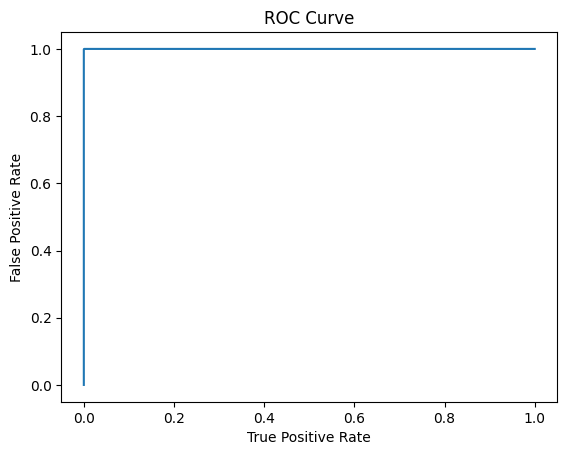

Training set areaUnderROC: 0.9999997289744393


In [ ]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [ ]:
spark.stop()


Fatalities main data set. Join locations dataset and plot. See if there are certain hotspots. 

Remove year, month values because we are trying to determine risk. 